# Global sea-level budget
Compute the sea-level budget as a function of time based on [ocean mass](http://dx.doi.org/10.1002/2014JB011547) and [steric](http://www.nature.com/nclimate/journal/v4/n11/full/nclimate2387.html) effects.   
The ice contribution of [Antarctica](10.1002/2014JB011547) and [Greenland](10.1002/2014JB011547) are also shown. 

In [1]:
import pathlib
import datetime

# data
import netCDF4
import pandas as pd
import numpy as np
import xarray as xr


# plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm

# stats
import statsmodels.stats.outliers_influence
import statsmodels.sandbox.regression.predstd
import statsmodels.graphics.regressionplots
import statsmodels.regression
import statsmodels.tsa.seasonal
import scipy.interpolate

# interaction
import tqdm
from IPython.display import YouTubeVideo, display

%matplotlib inline


greenish = list(matplotlib.rcParams['axes.prop_cycle'])[8]['color']

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
data_dir = pathlib.Path('../../../data/nasa').resolve()

In [3]:
gmsl_path = data_dir / 'GMSL_TPJAOS_5.1_199209_202206.txt'
ocean_mass_path = data_dir / 'ocean_mass_200204_202207.txt'
# 'http://data.nodc.noaa.gov/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/NETCDF/heat_content/mean_thermosteric_sea_level_anomaly_0-2000_seasonal.nc'
steric_path = data_dir / 'mean_total_steric_sea_level_anomaly_0-2000_seasonal.nc'
greenland_path = data_dir / 'greenland_mass_200204_202207.txt'
antarctica_path = data_dir / 'antarctica_mass_200204_202207.txt'



<AxesSubplot:xlabel='year'>

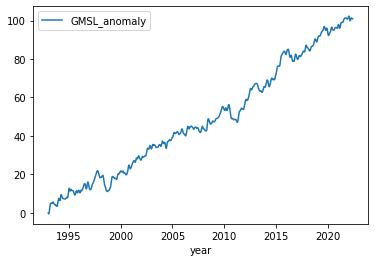

In [4]:
description = [
    'altimeter type 0=dual-frequency  999=single frequency (ie Poseidon-1)',
    'merged file cycle #',
    'year+fraction of year (mid-cycle)',
    'number of observations',
    'number of weighted observations',
    'GMSL (Global Isostatic Adjustment (GIA) not applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference',
    'standard deviation of GMSL (GIA not applied) variation estimate (mm)',
    'smoothed (60-day Gaussian type filter) GMSL (GIA not applied) variation (mm)  with respect to 20-year mean',
    'GMSL (Global Isostatic Adjustment (GIA) applied) variation (mm) )  with respect to 20-year mean',
    'standard deviation of GMSL (GIA applied) variation estimate (mm)',
    'smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm) )  with respect to 20-year mean',
    'smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm); annual and semi-annual signal removed )  with respect to 20-year mean'
],
columns = [
    'altimeter type',
    'file cycle #',
    'year',
    'n observations',
    'n weighted observations',
    'GMSL',
    'GMSL_sd',
    'GMSL_smooth',
    'GMSL_gia',
    'GMSL_gia_sd',
    'GMSL_gia_smooth',
    'GMSL_gia_smooth_deseasoned'
]
    

gmsl_df = pd.read_csv(gmsl_path, comment='H', sep='\s+', names=columns)
gmsl_df['GMSL_anomaly'] = gmsl_df['GMSL_gia_smooth_deseasoned'] - gmsl_df['GMSL_gia_smooth_deseasoned'].iloc[0]
# this plot should match with https://sealevel.nasa.gov/
gmsl_df.plot('year', 'GMSL_anomaly')


<AxesSubplot:xlabel='year'>

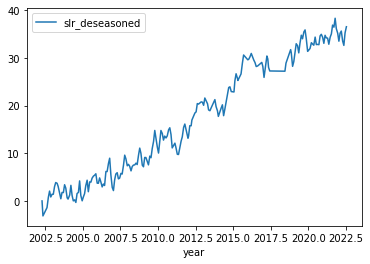

In [5]:
columns = ["year", "slr", "slr_sd", "slr_deseasoned"]
ocean_mass_df = pd.read_csv(ocean_mass_path,  comment='H', sep='\s+', names=columns)
ocean_mass_df.plot('year', 'slr_deseasoned')

months since 1955-01-01 00:00:00


<AxesSubplot:xlabel='year_frac'>

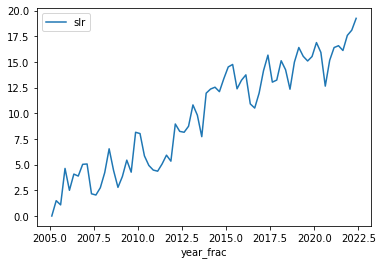

In [6]:
steric_ds = xr.open_dataset(steric_path, decode_times=False)
steric_df = steric_ds[['seas_s_mm_WO']].to_pandas().reset_index()
print(steric_ds['time'].units)
steric_df['month'] = np.ceil(steric_df['time'] % 12).astype('int') 
# should match the time units
steric_df['year'] = (steric_df['time'] // 12).astype('int') + 1955
# Or 15 for the middle of the month
steric_df['date'] = steric_df.apply(lambda row: datetime.datetime(int(row.year), int(row.month), 1), axis=1)
steric_df['year_frac'] = steric_df['time'] / 12 + 1955
steric_df['slr'] = steric_df['seas_s_mm_WO'] - steric_df['seas_s_mm_WO'].iloc[0]
steric_df.plot('year_frac', 'slr')


<AxesSubplot:xlabel='year'>

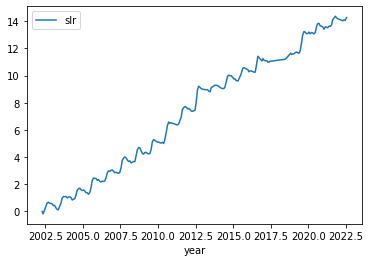

In [7]:
columns = ["year", "mass", "mass_sd"]
ocean_surface = 3.619e+14       # m2

greenland_df = pd.read_csv(greenland_path,  comment='H', sep='\s+', names=columns)
# gigatonne, assuming metric to kg, * 1l/kg * m3/l
greenland_df['volume'] = greenland_df['mass'] * 1e12 * 1.0 * 1e-3
greenland_df['slr'] = -greenland_df['volume'] / ocean_surface
# m -> mm
greenland_df['slr'] *= 1000
greenland_df.plot('year', 'slr')


<AxesSubplot:xlabel='year'>

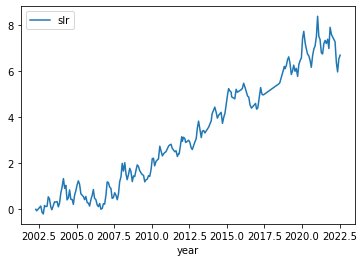

In [8]:
columns = ["year", "mass", "mass_sd"]
ocean_surface = 3.619e+14       # m2

antarctica_df = pd.read_csv(antarctica_path,  comment='H', sep='\s+', names=columns)
# gigatonne, assuming metric to kg, * 1l/kg * m3/l
antarctica_df['volume'] = antarctica_df['mass'] * 1e12 * 1.0 * 1e-3
antarctica_df['slr'] = -antarctica_df['volume'] / ocean_surface
# m -> mm
antarctica_df['slr'] *= 1000
antarctica_df.plot('year', 'slr')


<AxesSubplot:xlabel='year'>

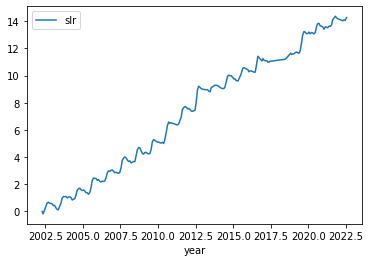

In [9]:
columns = ["year", "mass", "mass_sd"]
ocean_surface = 3.619e+14       # m2

greenland_df = pd.read_csv(greenland_path,  comment='H', sep='\s+', names=columns)
# gigatonne, assuming metric to kg, * 1l/kg * m3/l
greenland_df['volume'] = greenland_df['mass'] * 1e12 * 1.0 * 1e-3
greenland_df['slr'] = -greenland_df['volume'] / ocean_surface
# m -> mm
greenland_df['slr'] *= 1000
greenland_df.plot('year', 'slr')


In [10]:
ocean_mass_df.slr_deseasoned

0       0.00
1      -3.15
2      -1.41
3       0.77
4       2.06
       ...  
206    35.67
207    33.58
208    32.66
209    35.29
210    36.58
Name: slr_deseasoned, Length: 211, dtype: float64

In [11]:
steric_df

,time,seas_s_mm_WO,month,year,date,year_frac,slr
0,601.5,12.579991,2,2005,2005-02-01,2005.125,0.000000
1,604.5,14.072923,5,2005,2005-05-01,2005.375,1.492931
2,607.5,13.665286,8,2005,2005-08-01,2005.625,1.085295
3,610.5,17.212769,11,2005,2005-11-01,2005.875,4.632777
4,613.5,15.083118,2,2006,2006-02-01,2006.125,2.503127
...,...,...,...,...,...,...,...
65,796.5,29.159626,5,2021,2021-05-01,2021.375,16.579636
66,799.5,28.693142,8,2021,2021-08-01,2021.625,16.113152
67,802.5,30.163347,11,2021,2021-11-01,2021.875,17.583355
68,805.5,30.668837,2,2022,2022-02-01,2022.125,18.088844


In [12]:
# combine ocean and steric
ocean_slr = scipy.interpolate.interp1d(ocean_mass_df.year, ocean_mass_df.slr_deseasoned, bounds_error=False)(steric_df.year)
ocean_and_steric = pd.DataFrame(data=dict(year=steric_df.year, steric_slr=steric_df.slr, ocean_slr=ocean_slr))

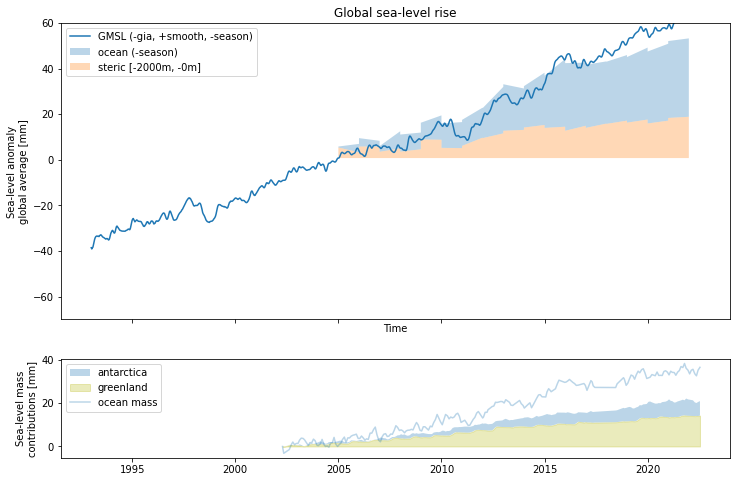

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3, 1]))
axes[0].set_title('Global sea-level rise')
# get the start of te ocean dataset
idxmin = np.abs(gmsl_df.year - ocean_and_steric.year.iloc[0]).idxmin()
GMSL_se = gmsl_df.GMSL_sd/np.sqrt(gmsl_df['n observations'])

# line up at start of series
correction = gmsl_df.GMSL_gia_smooth_deseasoned.iloc[idxmin]

axes[0].plot(gmsl_df.year, gmsl_df.GMSL_gia_smooth_deseasoned, label='GMSL (-gia, +smooth, -season)')

axes[0].fill_between(ocean_and_steric['year'], correction + ocean_and_steric['steric_slr'], correction  + ocean_and_steric['steric_slr'] + ocean_and_steric['ocean_slr'], alpha=0.3, label='ocean (-season)')
axes[0].fill_between(ocean_and_steric['year'], correction + ocean_and_steric['steric_slr'], correction, alpha=0.3, label='steric [-2000m, -0m]')

axes[1].fill_between(greenland_df['year'], y1=greenland_df['slr'], y2=greenland_df['slr'] + antarctica_df['slr'], alpha=0.3, label='antarctica')
axes[1].fill_between(antarctica_df['year'], greenland_df['slr'], alpha=0.3, label='greenland', color=greenish)
axes[1].plot(ocean_mass_df['year'], ocean_mass_df['slr_deseasoned'], alpha=0.3, label='ocean mass')

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Sea-level anomaly\nglobal average [mm]')



axes[0].set_ylim(-70, 60)
axes[0].legend(loc='best')
axes[1].set_ylabel('Sea-level mass\ncontributions [mm]')
axes[1].legend(loc='upper left')

In [14]:
fig.savefig('global-budget.pdf')